In [1]:
# -*- coding: utf-8 -*-

import meep as mp
import math
import numpy as np
import matplotlib.pyplot as plt

resolution = 50  # pixels/μm

sxy = 4
dpml = 1
cell = mp.Vector3(sxy+2*dpml,sxy+2*dpml,0)

pml_layers = [mp.PML(dpml)]

fcen = 1.0
df = 0.4
src_cmpt = mp.Ey
sources = [mp.Source(src=mp.GaussianSource(fcen,fwidth=df),
                    center=mp.Vector3(),
                    component=src_cmpt)]

if src_cmpt == mp.Ex:
    symmetries = [mp.Mirror(mp.X,phase=-1),
                  mp.Mirror(mp.Y,phase=+1)]
elif src_cmpt == mp.Ey:
    symmetries = [mp.Mirror(mp.X,phase=+1),
                  mp.Mirror(mp.Y,phase=-1)]
elif src_cmpt == mp.Ez:
    symmetries = [mp.Mirror(mp.X,phase=+1),
                  mp.Mirror(mp.Y,phase=+1)]

sim = mp.Simulation(cell_size=cell,
                    resolution=resolution,
                    sources=sources,
                    symmetries=symmetries,
                    boundary_layers=pml_layers)

nearfield_box = sim.add_near2far(fcen, 0, 1,
                                 mp.Near2FarRegion(mp.Vector3(y=0.5*sxy), size=mp.Vector3(sxy)),
                                 mp.Near2FarRegion(mp.Vector3(y=-0.5*sxy), size=mp.Vector3(sxy), weight=-1),
                                 mp.Near2FarRegion(mp.Vector3(0.5*sxy), size=mp.Vector3(y=sxy)),
                                 mp.Near2FarRegion(mp.Vector3(-0.5*sxy), size=mp.Vector3(y=sxy), weight=-1))

flux_box = sim.add_flux(fcen, 0, 1,
                        mp.FluxRegion(mp.Vector3(y=0.5*sxy), size=mp.Vector3(sxy)),
                        mp.FluxRegion(mp.Vector3(y=-0.5*sxy), size=mp.Vector3(sxy), weight=-1),
                        mp.FluxRegion(mp.Vector3(0.5*sxy), size=mp.Vector3(y=sxy)),
                        mp.FluxRegion(mp.Vector3(-0.5*sxy), size=mp.Vector3(y=sxy), weight=-1))

sim.run(until_after_sources=mp.stop_when_fields_decayed(50, src_cmpt, mp.Vector3(), 1e-8))

-----------
Initializing structure...
field decay(t = 50.01): 4938.653280565284 / 4938.653280565284 = 1.0
field decay(t = 100.01): 7.375043763791655e-11 / 4938.653280565284 = 1.493330943642899e-14
run 0 finished at t = 100.01 (10001 timesteps)


In [2]:
near_flux = mp.get_fluxes(flux_box)[0]

r = 1000/fcen      # half side length of far-field square box OR radius of far-field circle
res_ff = 1         # resolution of far fields (points/μm)
far_flux_box = (nearfield_box.flux(mp.Y, mp.Volume(center=mp.Vector3(y=r), size=mp.Vector3(2*r)), res_ff)[0]
               - nearfield_box.flux(mp.Y, mp.Volume(center=mp.Vector3(y=-r), size=mp.Vector3(2*r)), res_ff)[0]
               + nearfield_box.flux(mp.X, mp.Volume(center=mp.Vector3(r), size=mp.Vector3(y=2*r)), res_ff)[0]
               - nearfield_box.flux(mp.X, mp.Volume(center=mp.Vector3(-r), size=mp.Vector3(y=2*r)), res_ff)[0])

npts = 100         # number of points in [0,2*pi) range of angles
angles = 2*math.pi/npts*np.arange(npts)

E = np.zeros((npts,3),dtype=np.complex128)
H = np.zeros((npts,3),dtype=np.complex128)
for n in range(npts):
    ff = sim.get_farfield(nearfield_box,
                          mp.Vector3(r*math.cos(angles[n]),
                                     r*math.sin(angles[n])))
    E[n,:] = [np.conj(ff[j]) for j in range(3)]
    H[n,:] = [ff[j+3] for j in range(3)]

Px = np.real(np.multiply(E[:,1],H[:,2])-np.multiply(E[:,2],H[:,1]))
Py = np.real(np.multiply(E[:,2],H[:,0])-np.multiply(E[:,0],H[:,2]))
Pr = np.sqrt(np.square(Px)+np.square(Py))

far_flux_circle = np.sum(Pr)*2*np.pi*r/len(Pr)

print("flux:, {:.6f}, {:.6f}, {:.6f}".format(near_flux,far_flux_box,far_flux_circle))

flux:, 1.227787, 1.227651, 1.227260


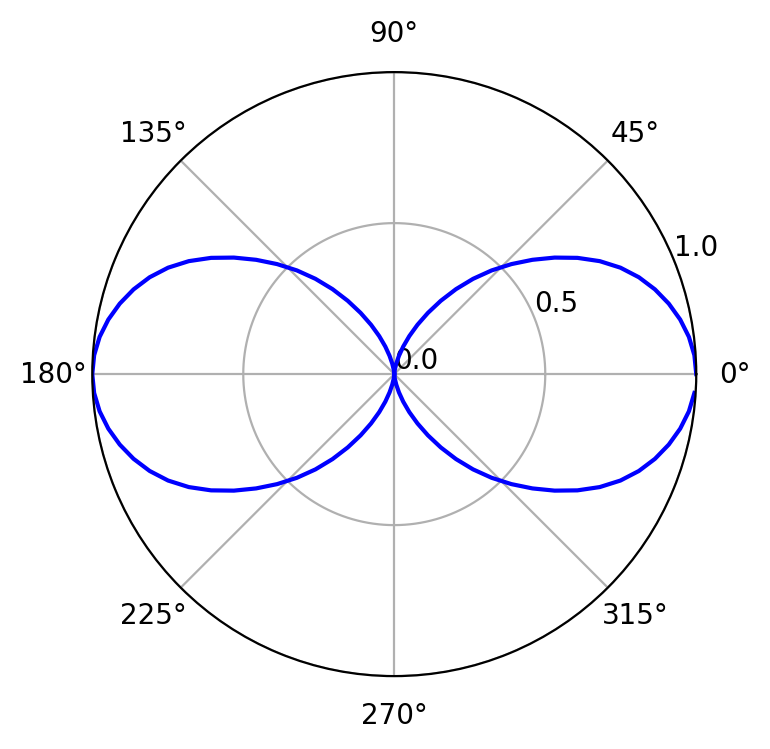

In [3]:
plt.figure(dpi=200)
ax = plt.subplot(111, projection='polar')
ax.plot(angles,Pr/max(Pr),'b-')
ax.set_rmax(1)
ax.set_rticks([0,0.5,1])
ax.grid(True)
ax.set_rlabel_position(22)